# Locomotion tracking in Pigeons

This is the code we used for the SfN 2022 Abstract submission on [3d tracking of freely moving pigeons reveals behavioral differences during space and color discrimination tasks](https://www.abstractsonline.com/cSubmit/SubmitPrinterFriendlyVersion.asp?ControlKey=EB4BB529%2D4271%2D43E7%2DB33B%2DB8C48A36B8E3&MeetingActivityKey=%7BA8A513A0%2DB922%2D40E7%2D93BC%2D326953EB0E67%7D&AKey=%7B3A7DC0B9%2DD787%2D44AA%2DBD08%2DFA7BB2FE9004%7D&MKey=%7B1446E249%2D2838%2D4164%2D8E59%2D5FAC2EE2F3C2%7D). 

Download this notebook in the upper right corner as .ipynb file and install `geopandas` to follow along. We used 3D reconstructed pigeon poses using the PigeonSuperModel, DeepLabCut and Anipose:

* Load 3D data from Anipose
    * Extract Arena Reference
    * Reduce Pigeon Pose
* Analyze Kinematic Profiles
    * Resample data Resolution
* Count Frames on Quadrant
    * Plot Spatial Distribution


In [1]:
# import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.ops import triangulate
from shapely.geometry import Polygon, Point, MultiPolygon, MultiPoint

## Helper Functions

In [ ]:
def fit_pointmap(grain, points):
    # create points with x and y coordinates
    pointmap = []
    shape = Polygon(points)
    
    # create a horizontal, equidistant line of point between with `grain` number of points 
    for x in np.linspace(min(MultiPoint(points).bounds), max(MultiPoint(points).bounds), grain, dtype = float):

        # create a vertical, equidistant line of point between with `grain` number of points 
        for y in np.linspace(min(MultiPoint(points).bounds), max(MultiPoint(points).bounds), grain, dtype = float):
            
            # within the double loop, define point with x and y coordinates
            p = Point(x,y)

            # filter points outside the original hexagon arena
            if shape.contains(p):
                pointmap.append(p)
    
    return pointmap
    
def fit_quadrants(map, step):
    # initialize quad_size
    quad_size = 0
    
    # initialize quadrants
    quadrants = [p.buffer(quad_size, cap_style=3) for p in map]

    while MultiPolygon(quadrants).is_valid:
        quad_size += step

        # create quadrant grid
        quadrants = [p.buffer(quad_size, cap_style=3) for p in map]

    return quad_size, quadrants

## Load 3D datasets

In [ ]:
# P175: last space autoshaping 
filename_1 = r'/Users/guillermo/Sciebo/Workspace/HexArenaData/merged_20220309_HexagonalArena_P175.csv'
# P171: first space discrimination
filename_2 = r'/Users/guillermo/Sciebo/Workspace/HexArenaData/merged_20220310_HexagonalArena_P171.csv'
# P172: color discrimination
filename_3 = r'/Users/guillermo/Sciebo/Workspace/HexArenaData/merged_20220330_HexagonalArena_P172.csv'

df1 = pd.read_csv(filename_1)
df2 = pd.read_csv(filename_2)
df3 = pd.read_csv(filename_3)

### Extract Reference Points for Arena Reconstruction

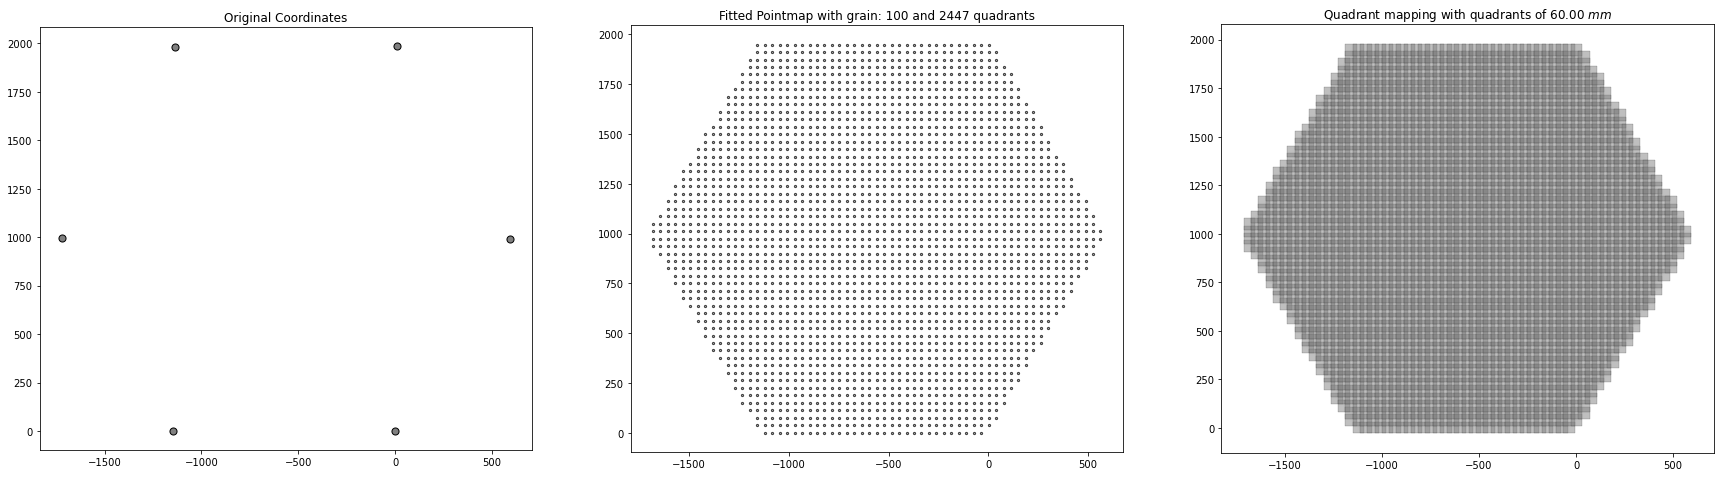

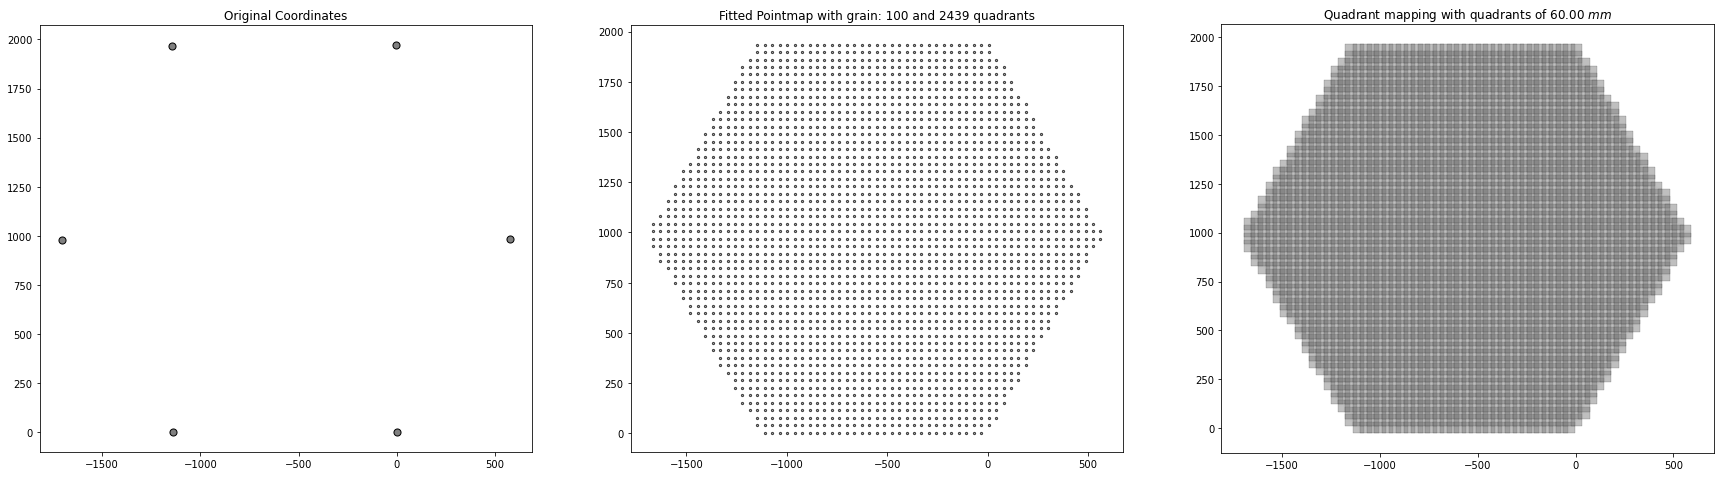

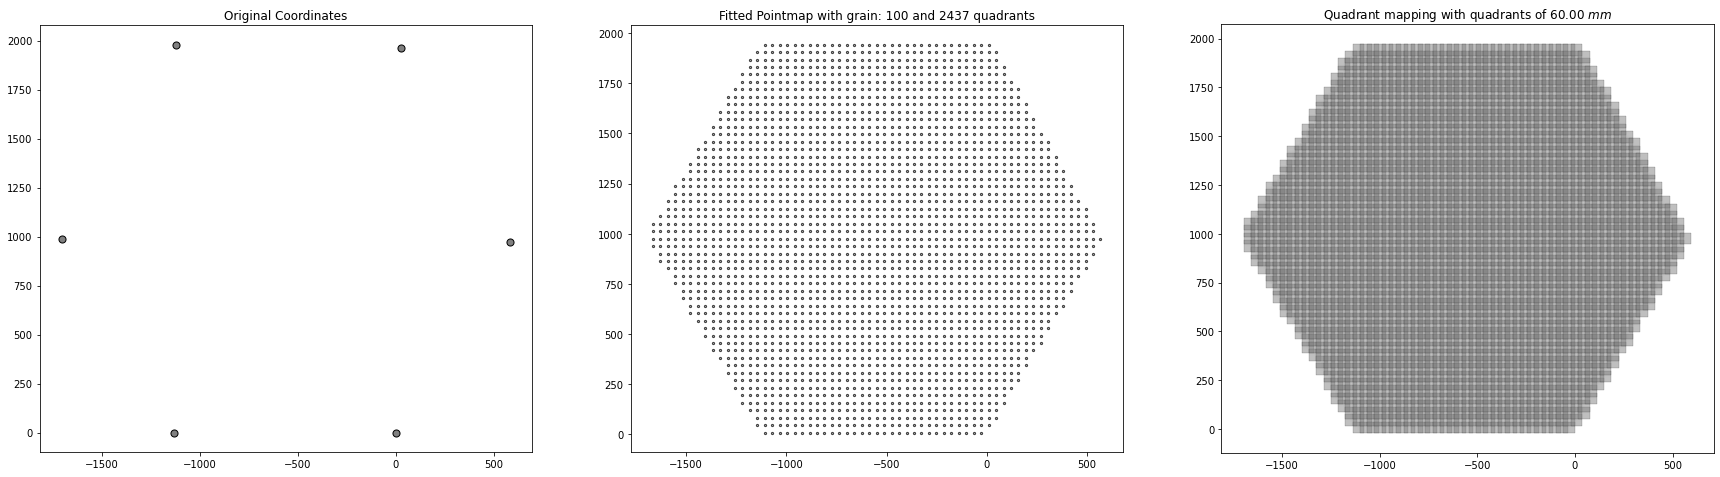

In [1046]:
for df in [df1, df2, df3]:
    # extract coordinates as points
    cA = np.array((df.loc[0,df.columns.str.contains('cA_x')], df.loc[0,df.columns.str.contains('cA_y')], df.loc[0,df.columns.str.contains('cA_z')]))
    cB = np.array((df.loc[0,df.columns.str.contains('cB_x')], df.loc[0,df.columns.str.contains('cB_y')], df.loc[0,df.columns.str.contains('cB_z')]))
    cC = np.array((df.loc[0,df.columns.str.contains('cC_x')], df.loc[0,df.columns.str.contains('cC_y')], df.loc[0,df.columns.str.contains('cC_z')]))
    cD = np.array((df.loc[0,df.columns.str.contains('cD_x')], df.loc[0,df.columns.str.contains('cD_y')], df.loc[0,df.columns.str.contains('cD_z')]))
    cE = np.array((df.loc[0,df.columns.str.contains('cE_x')], df.loc[0,df.columns.str.contains('cE_y')], df.loc[0,df.columns.str.contains('cE_z')]))
    cF = np.array((df.loc[0,df.columns.str.contains('cF_x')], df.loc[0,df.columns.str.contains('cF_y')], df.loc[0,df.columns.str.contains('cF_z')]))
    hexagonpoints = [Point(cA), Point(cB), Point(cC), Point(cD), Point(cE), Point(cF)]

    # select grid parameters
    grain = 100 # this defines how many quadrants to fit
    step = 30 # this defines degree of overlapping between quadrants

    map = fit_pointmap(grain, hexagonpoints)
    quad_size, quadrants = fit_quadrants(map, step)

    corners = gpd.GeoSeries(hexagonpoints)
    pointgrid = gpd.GeoSeries(map)
    quadgrid = gpd.GeoSeries(quadrants)

    # Plot Arena Mapping
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
    corners.plot(ax=ax1,
            color = 'gray',
            markersize = 50,
            linewidth = 1,
            edgecolors = 'black',
            alpha = 1);

    pointgrid.plot(ax=ax2,
            color = 'gray',
            markersize = 5,
            linewidth = 1,
            edgecolors = 'black',
            alpha = 0.7);

    quadgrid.plot(ax = ax3,
            color = 'gray', 
            linewidth = 0.3,
            edgecolors = 'black',
            alpha = 0.5);

    ax1.set_title('Original Coordinates');
    ax2.set_title(f'Fitted Pointmap with grain: {grain} and {len(quadgrid)} quadrants');
    ax3.set_title(f'Quadrant mapping with quadrants of {np.sqrt(quadrants[0].area):.2f} $mm$');

### Reduce Pigeon Pose to Spine Centroid

In [1048]:
timewindow = 5#  min
starttime = 20000 # frame
endtime = starttime + (timewindow*60*75)

pigeon1 = df1.loc[:, df1.columns.str.contains("UHS")]
pigeon1 = pigeon1.loc[starttime:endtime, pigeon1.columns.str.contains("x|y|z")]

pigeon2 = df2.loc[:, df2.columns.str.contains("UHS")]
pigeon2 = pigeon2.loc[starttime:endtime, pigeon2.columns.str.contains("x|y|z")]

pigeon3 = df3.loc[:, df3.columns.str.contains("UHS")]
pigeon3 = pigeon3.loc[starttime:endtime, pigeon3.columns.str.contains("x|y|z")]

## Analyze Kinematic Profile to Separate Stops from Bouts

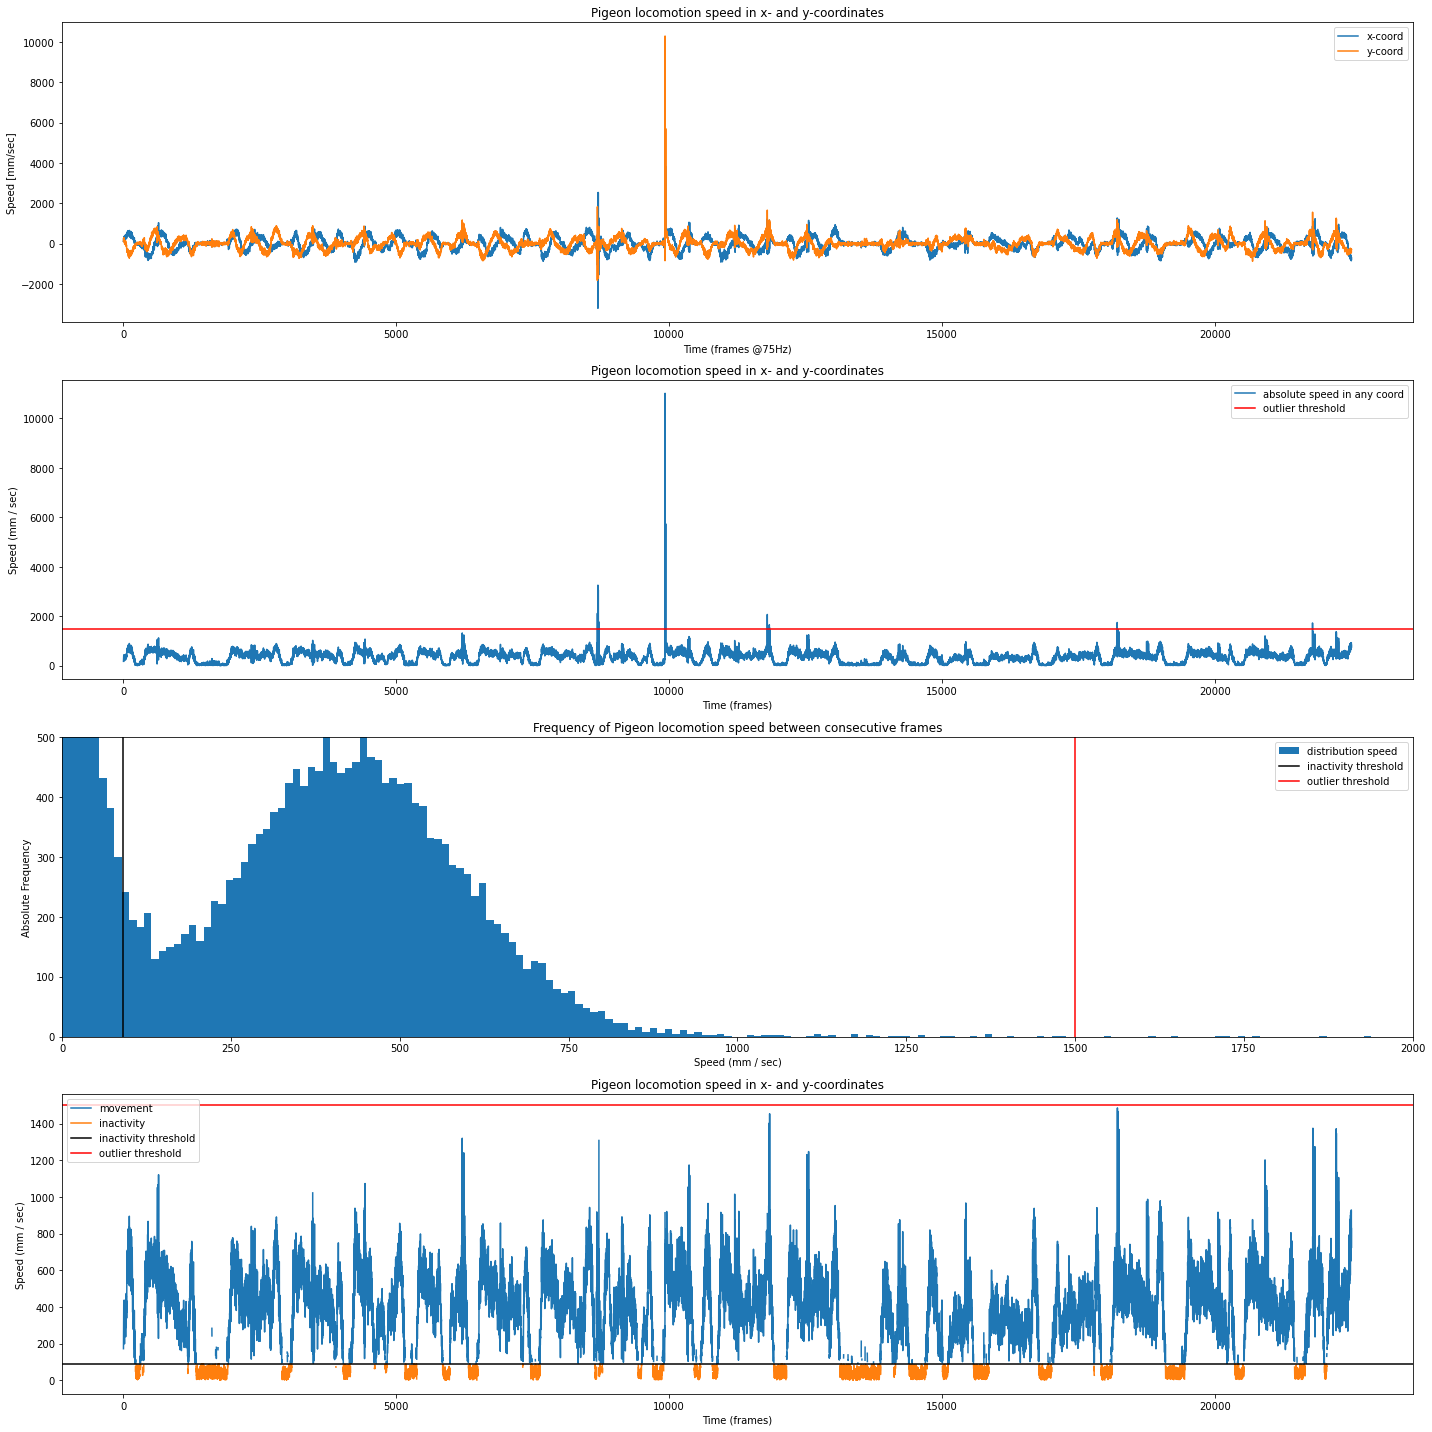

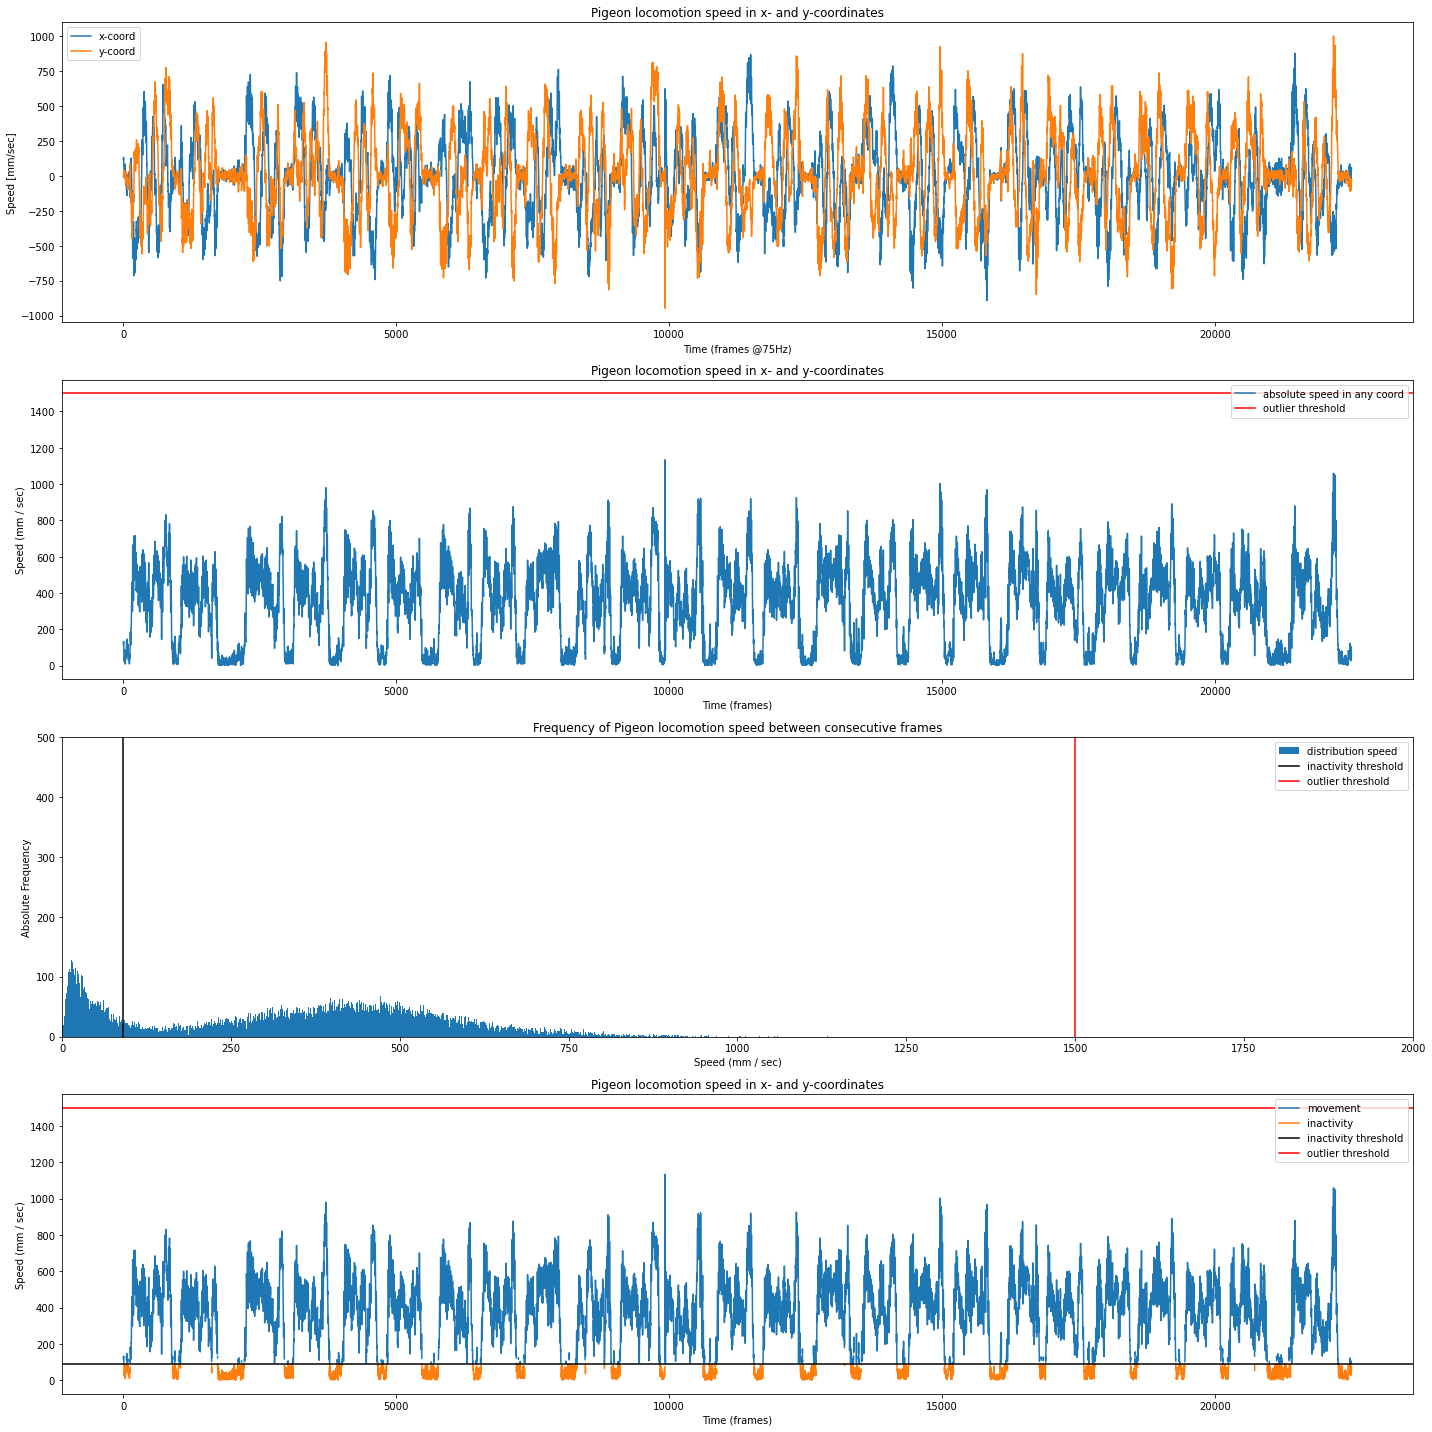

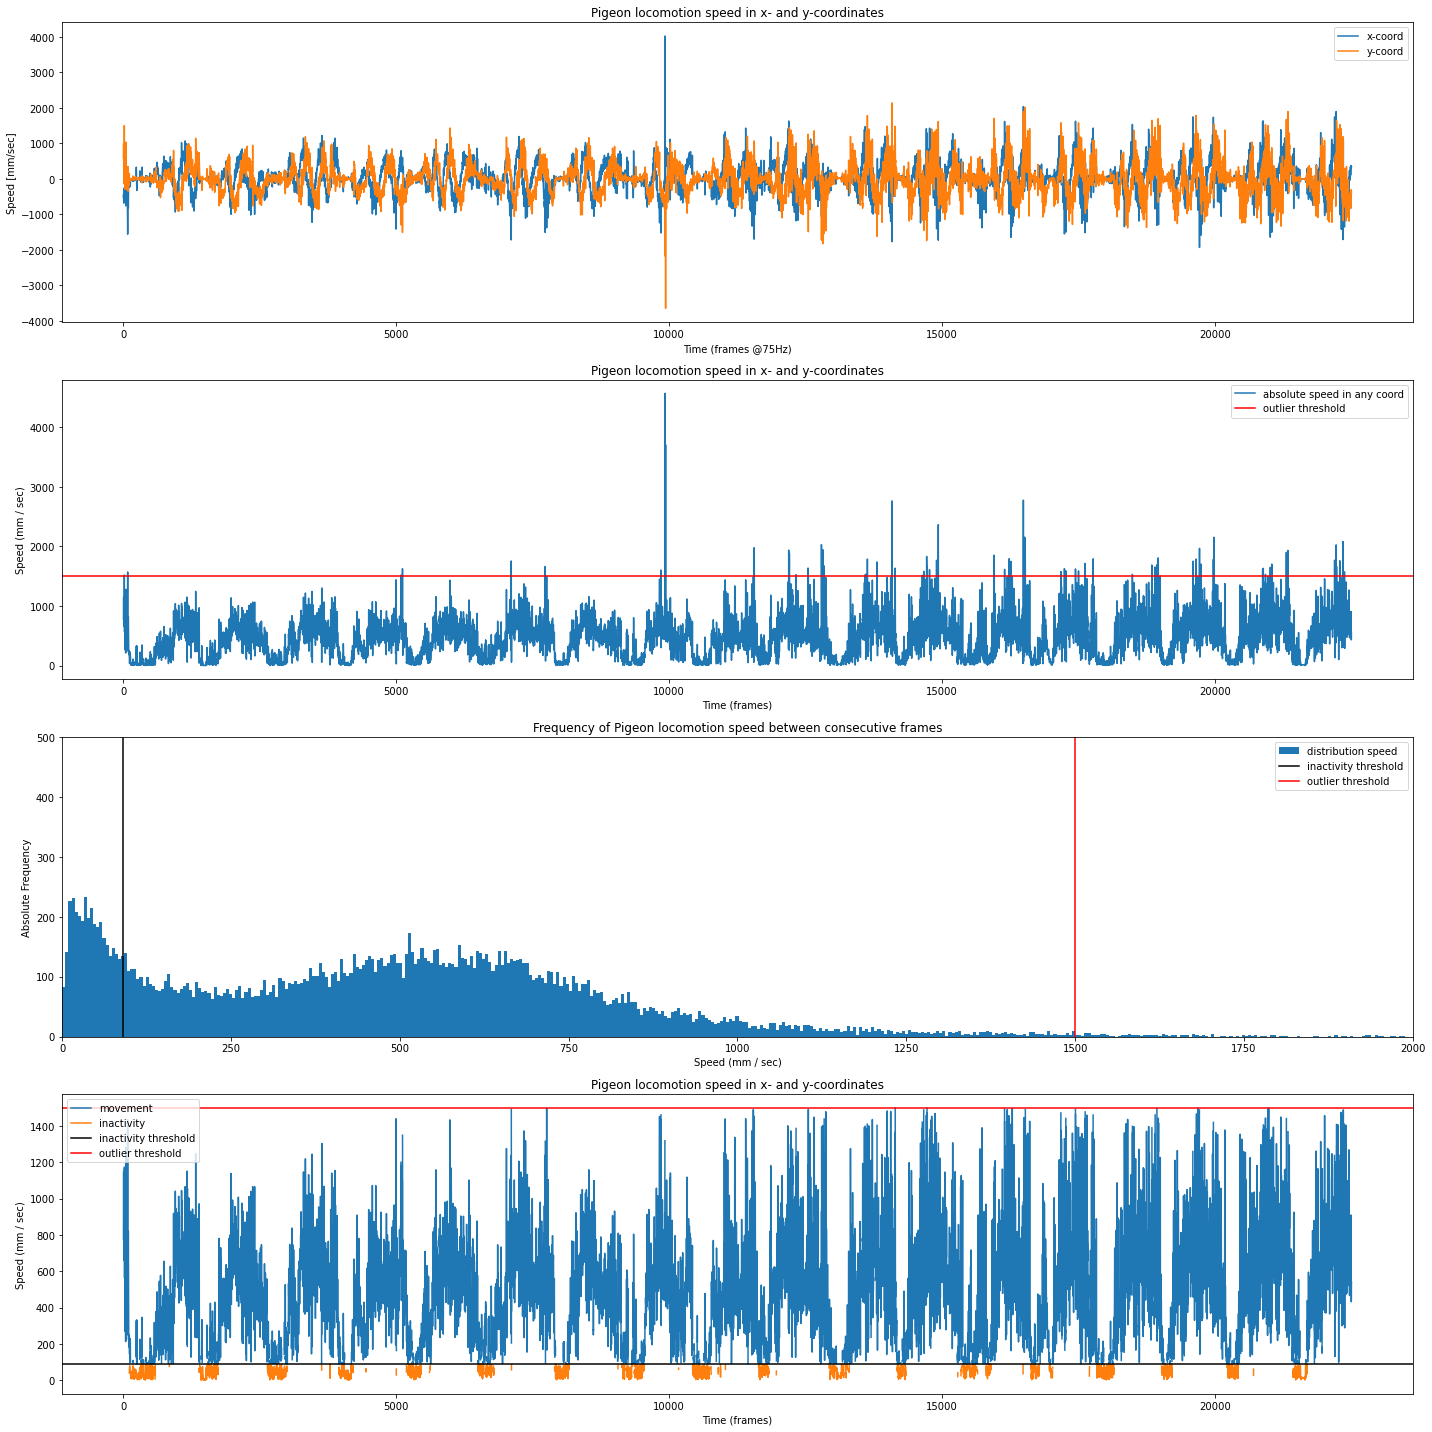

In [1052]:
all_stops = []
all_max_total_movement = []

for pigeon in [pigeon1, pigeon2, pigeon3]:
    # calculate speed as displacement between subsequent frames
    x = pigeon[pigeon.columns[pigeon.columns.str.contains("x")]].values
    y = pigeon[pigeon.columns[pigeon.columns.str.contains("y")]].values
    u = np.diff(x, n=1, axis=0) * 75 # conversion Hz to sec
    v = np.diff(y, n=1, axis=0) * 75

    # calculate absolute speed
    #total_speed = abs(u)+abs(v)
    total_speed = np.sqrt(u**2+v**2)

    # realistic boundries, see plot below
    inactivity = 90
    outlier = 1500

    # find stops
    stops = np.copy(total_speed)
    stops[stops>inactivity] = np.nan

    # find movement
    max_total_movement = np.copy(total_speed)
    max_total_movement[total_speed<inactivity] = np.nan
    max_total_movement[total_speed>outlier] = np.nan
    
    # save data
    all_stops.append(stops)
    all_max_total_movement.append(max_total_movement)
    
    # plot Kinematics
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20,20))
    # plot 1
    ax1.set(title = 'Pigeon locomotion speed in x- and y-coordinates', xlabel='Time (frames @75Hz)', ylabel='Speed [mm/sec]');
    ax1.plot(u, label = 'x-coord')
    ax1.plot(v, label = 'y-coord')
    ax1.legend();

    # plot 2
    ax2.set(title = 'Pigeon locomotion speed in x- and y-coordinates', xlabel='Time (frames)', ylabel='Speed (mm / sec)');
    ax2.plot(total_speed, label = 'absolute speed in any coord')
    ax2.axhline(y=outlier, color= 'red', label = 'outlier threshold')
    ax2.legend()

    # plot 3
    ax3.set(title = 'Frequency of Pigeon locomotion speed between consecutive frames', xlabel='Speed (mm / sec)', ylabel='Absolute Frequency');
    ax3.hist(total_speed, bins = 1000, label = 'distribution speed');
    ax3.axvline(x=inactivity, color= 'black', label = 'inactivity threshold')
    ax3.axvline(x=outlier, color= 'red', label = 'outlier threshold')
    ax3.set_ylim(0,500)
    ax3.set_xlim(0, 2000)
    ax3.legend()

    # plot 4
    ax4.set(title = 'Pigeon locomotion speed in x- and y-coordinates', xlabel='Time (frames)', ylabel='Speed (mm / sec)');
    ax4.plot(max_total_movement, label = 'movement')
    ax4.plot(stops, label = 'inactivity')
    ax4.axhline(y=inactivity, color= 'black', label = 'inactivity threshold')
    ax4.axhline(y=outlier, color= 'red', label = 'outlier threshold')
    ax4.legend();

    fig.tight_layout()
    plt.show()

In [1065]:
all_bout_events = []
for i in range(len(all_stops)):
    stop_events = [idx for idx in np.arange(len(all_stops[i])) if all_stops[i][idx]>0]
    print(f'Found {len(stop_events)} stop frames in {len(all_stops[i])} total frames [{100*len(stop_events)/len(all_stops[i]):.0f}%]')
    bout_events = [idx for idx in np.arange(len(all_max_total_movement[i])) if all_max_total_movement[i][idx]>0]
    print(f'Found {len(bout_events)} movement frames in {len(all_max_total_movement[i])} total frames [{100*len(bout_events)/len(all_max_total_movement[i]):.0f}%]')
    outliers = len(all_max_total_movement[i]) - (len(stop_events) + len(bout_events))
    print(f'Found {outliers} outlier frames in {len(all_max_total_movement[i])} total frames [{100*outliers/len(all_max_total_movement[i]):.3f}%]')
    all_bout_events.append(bout_events)

Found 4737 stop frames in 22500 total frames [21%]
Found 17746 movement frames in 22500 total frames [79%]
Found 17 outlier frames in 22500 total frames [0.076%]
Found 4940 stop frames in 22500 total frames [22%]
Found 17560 movement frames in 22500 total frames [78%]
Found 0 outlier frames in 22500 total frames [0.000%]
Found 3438 stop frames in 22500 total frames [15%]
Found 18881 movement frames in 22500 total frames [84%]
Found 181 outlier frames in 22500 total frames [0.804%]


### Resample Data resolution

In [1067]:
all_res_pigeon_bouts = []
for pigeon in [pigeon1, pigeon2, pigeon3]:
    # subset stops
    pigeon_stops = pigeon.iloc[stop_events]
    pigeon_bouts = pigeon.iloc[bout_events]

    # resample stops
    fps = 75
    res_fps = 30
    length = len(pigeon_stops)
    res_length = length/fps*res_fps
    chunks = int(length/(length/res_length))
    res_index = np.linspace(0, length-1, num=chunks)
    res_pigeon_stops = pigeon_stops.iloc[res_index].reset_index(drop=True)

    # resample bouts
    length = len(pigeon_bouts)
    res_length = length/fps*res_fps
    chunks = int(length/(length/res_length))
    res_index = np.linspace(0, length-1, num=chunks)
    res_pigeon_bouts = pigeon_bouts.iloc[res_index].reset_index(drop=True)
    all_res_pigeon_bouts.append(res_pigeon_bouts)


res_pigeon_bouts1 = all_res_pigeon_bouts[0]
res_pigeon_bouts2 = all_res_pigeon_bouts[1]
res_pigeon_bouts3 = all_res_pigeon_bouts[2]

## Count Frames on Quadrant for Spatial Distribution

In [1070]:
# calculate pigeon path

# Find point in polygon
visits1 = []
visits2 = []
visits3 = []

## P1
# get coordinates in every time frame
for t in range(len(res_pigeon_bouts1)):
    p = Point(res_pigeon_bouts1.iloc[t,:])
    # assign quadrant that contains pigeon location
    boollist = quadgrid.contains(p)
    [visits1.append(i) for i, x in enumerate(boollist) if x]

# count visit per quadrant index
counts = pd.Series(visits1).groupby(visits1).size().reindex(quadgrid.index, fill_value=0)

# create GeoPandas Data Frame
boutcount1 = gpd.GeoDataFrame(pd.concat([counts, quadgrid], axis=1))
boutcount1.columns = ["visits", "geometry"]

## P2
# get coordinates in every time frame
for t in range(len(res_pigeon_bouts2)):
    p = Point(res_pigeon_bouts2.iloc[t,:])
    # assign quadrant that contains pigeon location
    boollist = quadgrid.contains(p)
    [visits2.append(i) for i, x in enumerate(boollist) if x]

# count visit per quadrant index
counts = pd.Series(visits2).groupby(visits2).size().reindex(quadgrid.index, fill_value=0)

# create GeoPandas Data Frame
boutcount2 = gpd.GeoDataFrame(pd.concat([counts, quadgrid], axis=1))
boutcount2.columns = ["visits", "geometry"]

## P3
# get coordinates in every time frame
for t in range(len(res_pigeon_bouts3)):
    p = Point(res_pigeon_bouts3.iloc[t,:])
    # assign quadrant that contains pigeon location
    boollist = quadgrid.contains(p)
    [visits3.append(i) for i, x in enumerate(boollist) if x]

# count visit per quadrant index
counts = pd.Series(visits3).groupby(visits3).size().reindex(quadgrid.index, fill_value=0)

# create GeoPandas Data Frame
boutcount3 = gpd.GeoDataFrame(pd.concat([counts, quadgrid], axis=1))
boutcount3.columns = ["visits", "geometry"]

### Plot Figures of Spatial Distribution

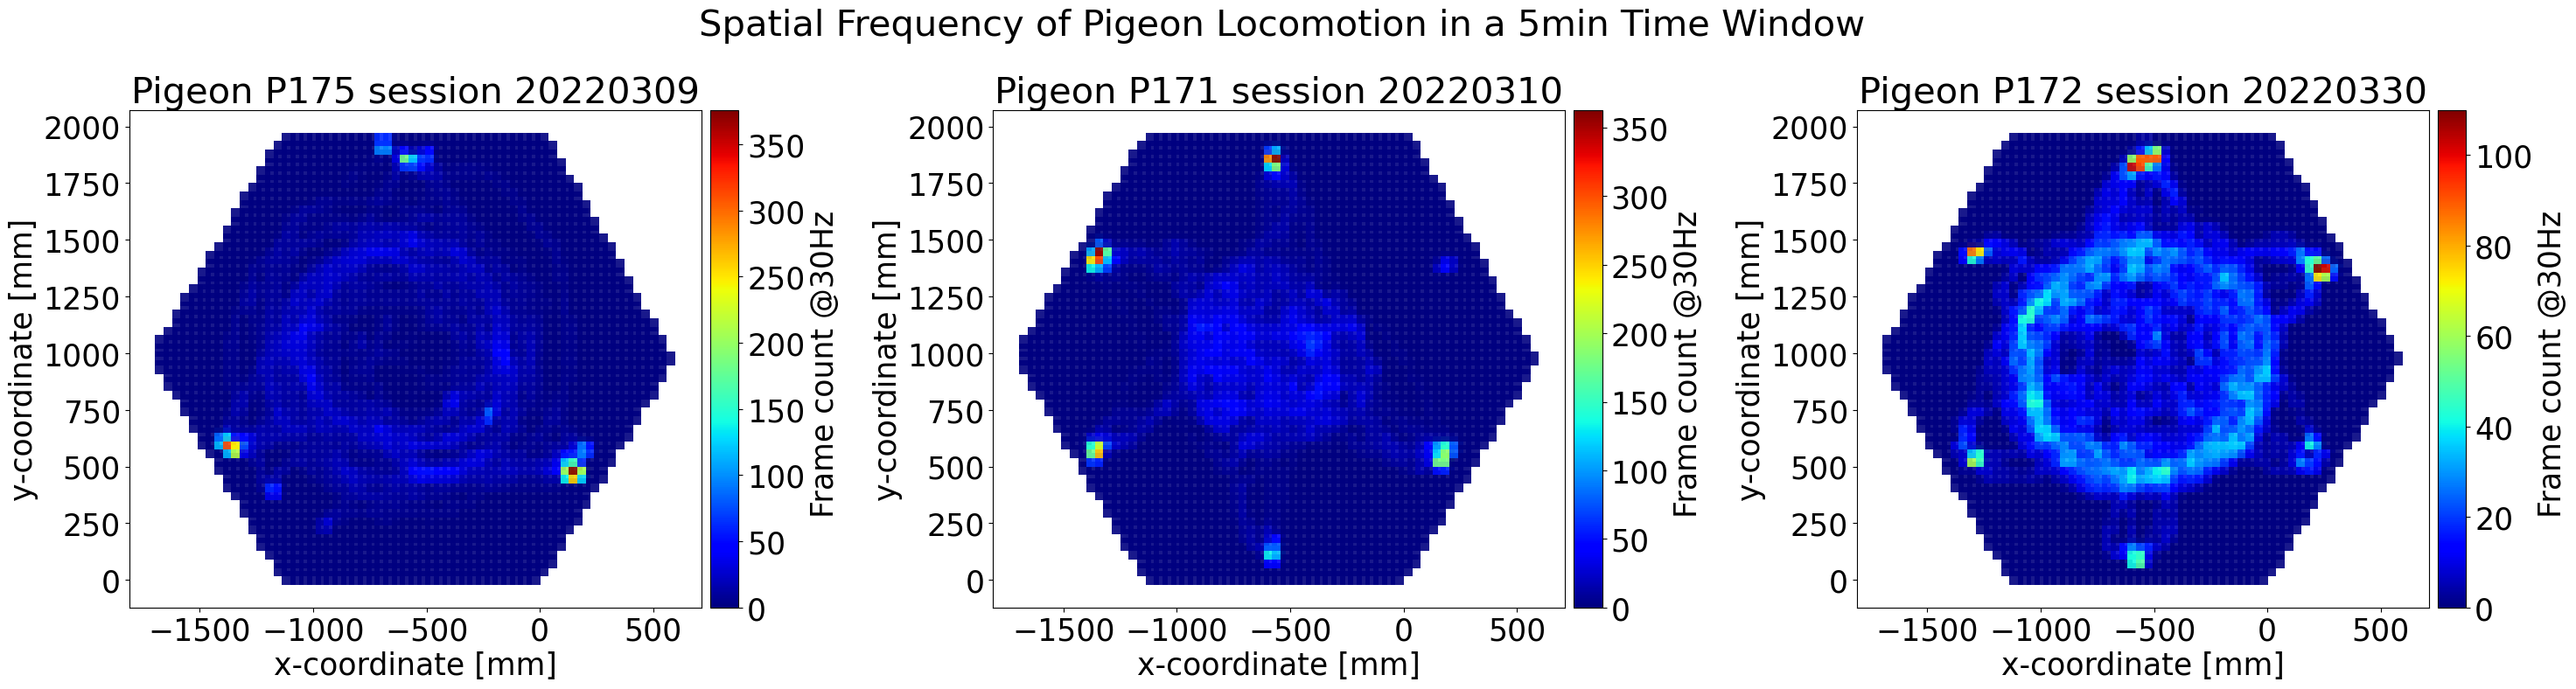

In [1086]:
plt.rcParams.update({'font.size':25})

# Plot Pigeon Locomotion
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,8))

# plot 1
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.1)
boutcount1.plot(column='visits',
        ax = ax1, 
        linewidth=1,
        cmap='jet',
        alpha = 0.9, legend=True, cax=cax1);

# plot 2
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.1)
boutcount2.plot(column='visits',
        ax = ax2, 
        linewidth=1,
        cmap='jet',
        alpha = 0.9, legend=True, cax=cax2);

# plot 3
divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes("right", size="5%", pad=0.1)
boutcount3.plot(column='visits',
        ax = ax3, 
        linewidth=1,
        cmap='jet',
        alpha = 0.9, legend=True, cax=cax3);

fig.suptitle("Spatial Frequency of Pigeon Locomotion in a 5min Time Window ")
ax1.set(title = 'Pigeon P175 session 20220309', xlabel='x-coordinate [mm]', ylabel='y-coordinate [mm]');
ax2.set(title = 'Pigeon P171 session 20220310', xlabel='x-coordinate [mm]', ylabel='y-coordinate [mm]');
ax3.set(title = 'Pigeon P172 session 20220330', xlabel='x-coordinate [mm]', ylabel='y-coordinate [mm]');

cax1.set_ylabel(f'Frame count @{res_fps}Hz ');
cax2.set_ylabel(f'Frame count @{res_fps}Hz ');
cax3.set_ylabel(f'Frame count @{res_fps}Hz ');

plt.tight_layout()
# reset
plt.rcdefaults()
